(ch:annulus)=
# Annulus & Local Sky

An [annulus](https://en.wikipedia.org/wiki/Annulus_(mathematics)) (plural can be annuli or annuluses) basically a circular ring. In astronomy, it can also be a random shaped ring-like shape, e.g., the region between two rectangles.

In [ ]:
# Ignore this cell if you encounter errors
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

In [2]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path
import numpy as np

from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus, 
                                aperture_photometry, ApertureStats)
from photutils.detection import DAOStarFinder

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

In [3]:
# 1. Load data
allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])
cut = Cutout2D(ccd, position=(273, 314), size=(100,100))

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In previous notes, you have learned how to detect objects in the image, and then how to set up apertures. Then you learned how to do photometry. The example I showed in the note, i.e., measuring the star's flux using the fluxes of two different apertures, are reasonable when a 2-D measurement is impossible. If we know the pixel values around the star (the 2-D information)

In this note, I will show you the power of 2-D analyses for obtaining better photometry.

First, result from the previous note as a reference:

In [59]:
# 1. Load data
allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])
ccd.data[310:320, 299] += np.arange(10)**2
ccd.data[280:290, 270] += 30*np.arange(10)**2
cut = Cutout2D(ccd, position=(273, 314), size=(100,100))

# 2. Set the two "apertures"
ap1 = CircularAperture(positions=cut.center_cutout, r=12)
ap2 = CircularAperture(positions=cut.center_cutout, r=24)
# I used radius 12 and 24 because I know the star is <20 pixels in diameter.
print("Inner aperture:\n", ap1)
print()
print("Outer aperture:\n", ap2)

# 3. Perform photometry
phot = aperture_photometry(cut.data, [ap1, ap2])
flux1 = phot['aperture_sum_0'][0]
flux2 = phot['aperture_sum_1'][0]

# 4. Calculate the sky flux and the total flux
flux_s = (flux2 - flux1) / (ap2.area - ap1.area)
flux0 = flux1 - flux_s * np.pi * 12**2

# 5. Print out the results
print(f"flux at aperture 1 and 2 are {flux1:.2f} and {flux2:.2f}")
print(f"sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = {flux_s:.2f}")
print(f"∴ flux0 = {flux0:.2f}")

Inner aperture:
 Aperture: CircularAperture
positions: [49.5, 49.5]
r: 12.0

Outer aperture:
 Aperture: CircularAperture
positions: [49.5, 49.5]
r: 24.0
flux at aperture 1 and 2 are 94631.81 and 206870.05
sky flux flux_s = (flux2 - flux1) / (π(24**2 - 12**2)) = 82.70
∴ flux0 = 57219.06


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


```{note} 
Take a note of the sky value 82.70 ADU/pix & flux 57219.06.
```

```{important} 
Before proceed, please read the **aperture mask part** of [photutils/Aperture](https://photutils.readthedocs.io/en/stable/aperture.html).
```

Now you have learned how to initialize an annulus (basically it is similar to `Aperture` object) and make a "mask" to extract the pixels in it. I will extract only the pixels with center is inside an annulus of inner/outer radii of 20 and 28:

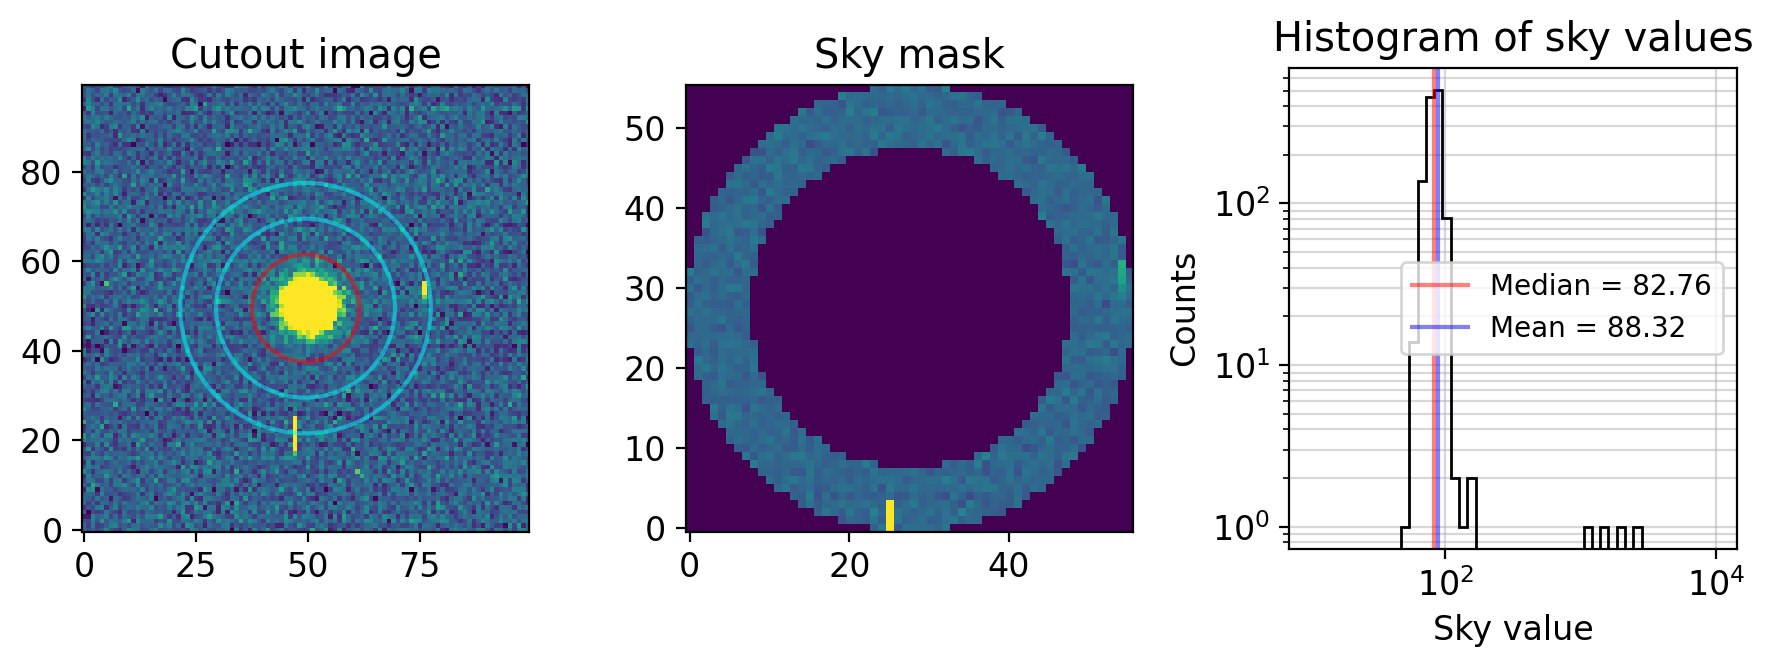

In [166]:
an1 = CircularAnnulus(positions=cut.center_cutout, r_in=20, r_out=28)
skymask = an1.to_mask(method='center')
skyvals = skymask.multiply(cut.data)
skyvals.mask = skymask.data==0
med = np.median(skyvals.compressed())
avg = np.mean(skyvals.compressed())

fig, axs = plt.subplots(1, 3, figsize=(9, 3.5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs[0], cut.data, zscale=True)
ap1.plot(axs[0], color='r', lw=1.5, alpha=0.5)
an1.plot(axs[0], color='cyan', lw=1.5, alpha=0.5)

vis.norm_imshow(axs[1], skymask.multiply(cut.data), zscale=True)
axs[2].hist(skyvals.flatten(), bins=np.logspace(1, 4, 50), histtype='step', color='k')
axs[2].grid(which='both', alpha=0.5)
axs[2].axvline(med, color='r', lw=1.5, alpha=0.5, label=f'Median = {med:.2f}')
axs[2].axvline(avg, color='b', lw=1.5, alpha=0.5, label=f'Mean = {avg:.2f}')

axs[0].set_title("Cutout image")
axs[1].set_title("Sky mask")
axs[2].set(title="Histogram of sky values",
           xscale='log', yscale="log", xlabel='Sky value', ylabel='Counts')
axs[2].legend(fontsize=10)
plt.tight_layout()
plt.show();


```{admonition} Practice
:class: tip
1. What does ``skymask.data`` mean? 
2. Why did I use ``skyvals[skymask.data==0] = np.nan``? (What will happen without this line?)
```

Now let me ask you. The flux within the red aperture will contain both the star's flux and the sky flux. And although I didn't mention explicitly, you can easily understand the sky annulus (cyan) is set to estimate this sky value. From the right panel, how would you calculate the sky value?

The histogram includes the distribution of the sky values. However, you can see some bright cosmic-ray spots at the right and bottom part in the annulus (that I artifically added when I loaded it for visualization purpose). Because of this, the histogram is slightly skewed to the right. Therefore, average and median are quite diffent, and you can see simple average value of the pixels is not a good option.

One suggestion: How about use sigma-clipping?

Number of rejected sky values: 11


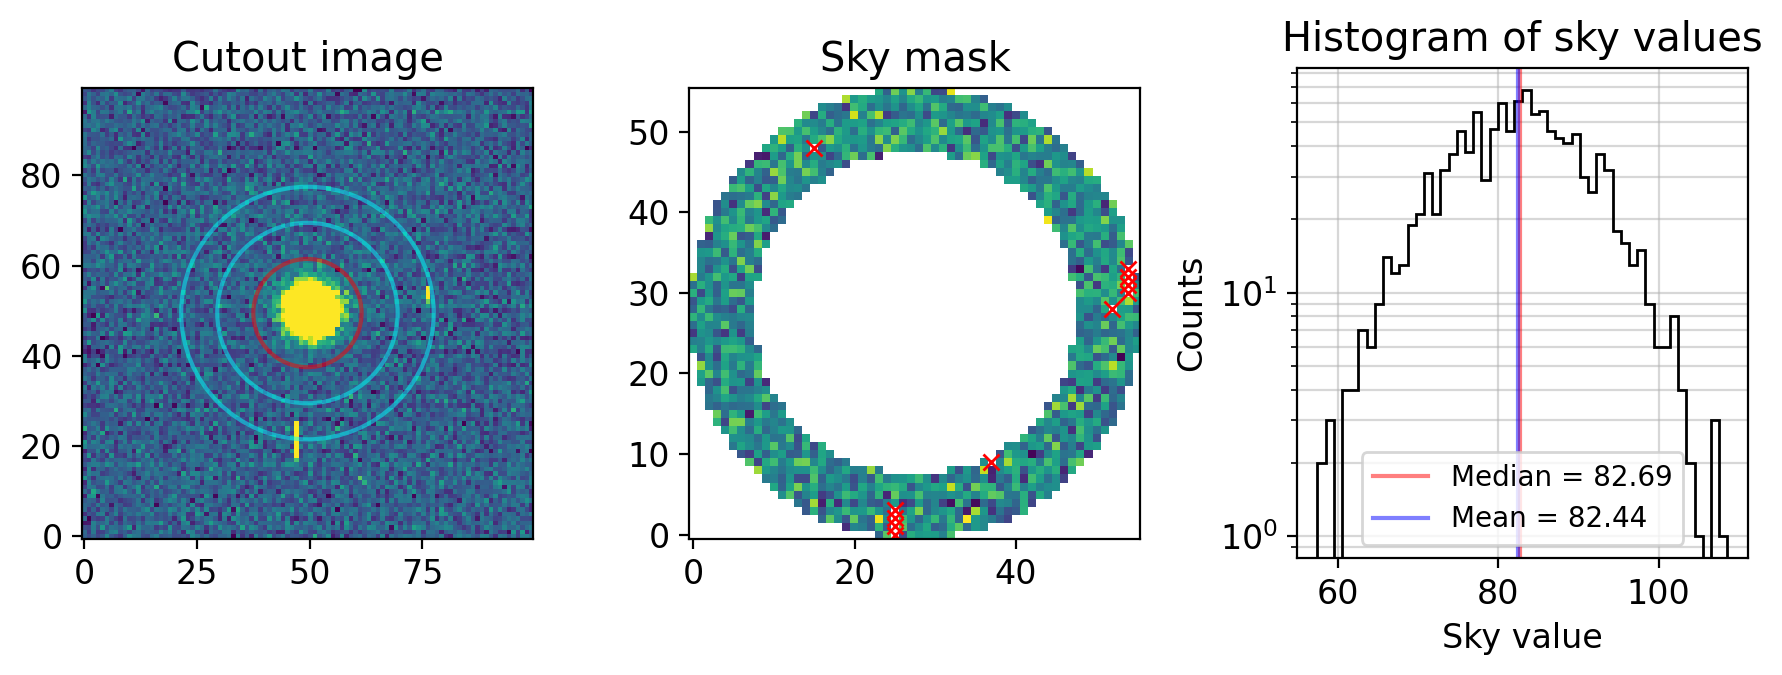

In [184]:
from astropy.stats import sigma_clip

sigc = sigma_clip(skyvals)  # default 3-sigma 5-iteration clipping
med = np.nanmedian(sigc.compressed())
avg = np.nanmean(sigc.compressed())
sigc_masked = skyvals.mask ^ sigc.mask  
# What is ^? --> Search for the "bitwise XOR operator in Python"
print("Number of rejected sky values:", np.sum(sigc_masked))

fig, axs = plt.subplots(1, 3, figsize=(9, 3.5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs[0], cut.data, zscale=True)
ap1.plot(axs[0], color='r', lw=1.5, alpha=0.5)
an1.plot(axs[0], color='cyan', lw=1.5, alpha=0.5)

skymap = skymask.multiply(cut.data)
skymap[sigc.mask] = np.nan
vis.norm_imshow(axs[1], skymap, zscale=True)
axs[1].plot(*np.argwhere(sigc_masked).T[::-1], "rx")

axs[2].hist(sigc.compressed(), bins=50, histtype='step', color='k')
axs[2].grid(which='both', alpha=0.5)
axs[2].axvline(med, color='r', lw=1.5, alpha=0.5, label=f'Median = {med:.2f}')
axs[2].axvline(avg, color='b', lw=1.5, alpha=0.5, label=f'Mean = {avg:.2f}')

axs[0].set_title("Cutout image")
axs[1].set_title("Sky mask")
axs[2].set(title="Histogram of sky values",
           yscale="log", xlabel='Sky value', ylabel='Counts')
axs[2].legend(fontsize=10)
plt.tight_layout()
plt.show();

Note that the 11 pixels masked in sigma-clipping are marked by red crosses and masked in this version of plot.

Also, the median and mean are now slightly lowered (because most rejections were for high pixel values) and they match quite well with each other.

For elementary photometry, this is ehough. Even for publication level, if we are sure there are no nearby objects, this is a reasonable guess ()

In [119]:
sigc.compressed()

array([ 74.18838501,  95.39729309,  69.27059937, ...,  68.38792419,
        69.2440567 , 106.67719269])

In [112]:
skymask.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Now the mean value is closer to median, which is what we would expect. 

In [109]:
np.nanmean(sigc.compressed())

82.44230733439638

Now the median and mean are 